In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from scipy.stats import pearsonr, spearmanr
from statsmodels.formula.api import ols
from tqdm import tqdm

In [2]:
def get_euler_dist(v1, v2):
    vi = np.array(v1).reshape([-1])
    vj = np.array(v2).reshape([-1])
    return np.sqrt(np.sum(np.square(vi - vj)))


def get_cos_similar(v1, v2):
    vi = np.array(v1).reshape([-1])
    vj = np.array(v2).reshape([-1])

    num = float(np.dot(vi, vj))  # 向量点乘
    denom = np.linalg.norm(vi) * np.linalg.norm(vj)  # 求模长的乘积
    return (num / denom) if denom != 0 else 0

In [7]:
# read pre-generated file
name2smile = json.load(open('./name_to_smile.json'))
submat = pd.read_csv('./data_c/mst_dists_submatrix.csv', index_col=0)
w2v_md = Word2Vec.load('./models/pubmed.model')

In [8]:
smile_embd = pd.read_csv('./smile_embedding.csv')
'''for idx, i_row in smile_embd.iterrows():
    for jdx, j_row in smile_embd[idx + 1:].iterrows():
        if i_row['iupac'].lower() == j_row['iupac'].lower():
            print(idx, jdx, i_row['iupac'], j_row['iupac'])
            smile_embd.drop(index=jdx, inplace=True)
smile_embd.to_csv('./smile_embedding.csv', index=False)'''
smile_embd

,iupac,smile,embd
0,(+)-aspidospermidine,CCC12CCCN3CCC4(C(CC1)Nc5ccccc45)C23,[-7.44335949e-01 9.23662633e-02 -3.57910395e-...
1,(-)-Adrenaline,CNCC(O)c1ccc(O)c(O)c1,[-8.14905405e-01 -2.59020120e-01 9.81947482e-...
2,(-)-Epicatechin,O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c3ccc(O)c(O)c3,[-7.76835263e-01 -5.64182363e-02 6.96076825e-...
3,(-)-Noradrenaline,NC[C@@H](O)c1ccc(O)c(O)c1,[-0.79306275 -0.2277208 -0.02243627 -0.283230...
4,(-)-deoxypodophyllotoxin,COc1cc(cc(OC)c1OC)[C@H]2[C@@H]3[C@H](COC3=O)Cc...,[-8.34411085e-01 1.37109548e-01 2.22313315e-...
...,...,...,...
968,viridicatin,OC1=C(c2ccccc2)c3ccccc3NC1=O,[-1.22181594e+00 -3.88474464e-01 1.42942384e-...
969,virosecurinine,O=C1OC23CC(C=CC2=C1)N4CCCCC34,[-7.39553794e-02 2.85954088e-01 2.40951285e-...
970,voacamine,CC[C@H]1C[C@@H]2CN3CCc4c([nH]c5cc([C@H]6C[C@@H...,[-7.72047281e-01 -5.36762737e-02 -2.30637938e-...
971,weddellite,O.O.[Ca++].[O-]C(=O)C([O-])=O,[-2.23173782e-01 5.28758690e-02 3.87791097e-...


In [9]:
names = []
mentions = []
semantic = []
smi_structure = []
geo_code = []

for idx, row in smile_embd.iterrows():
    nm = row['iupac']
    if nm in name2smile.keys():
        sm_strt = np.array([float(x) for x in row['embd'][1:-1].split()])
        mentions.append(w2v_md.wv.vocab[nm].count)
        semantic.append(w2v_md.wv[nm])
        names.append(nm)
        smi_structure.append(sm_strt)
        geo_code.append(name2smile[nm][1])
    else:
        print(nm)

df = pd.DataFrame({
    "name": names,
    "mentions": mentions,
    "smile": smi_structure,
    "geometric": geo_code,
    "semantic": semantic
})
df.to_csv("./rg_gsmi_geo_sem.csv", index=False)
df

,name,mentions,smile,geometric,semantic
0,(+)-aspidospermidine,15,"[-0.744335949, 0.0923662633, -0.357910395, -0....",[PATZIW],"[0.17337348, -0.3568789, 0.03349426, -0.342206..."
1,(-)-Adrenaline,21,"[-0.814905405, -0.25902012, 0.0981947482, -0.6...",[ADRENL],"[0.37826678, 0.060717285, 0.3967686, -0.020205..."
2,(-)-Epicatechin,129,"[-0.776835263, -0.0564182363, 0.0696076825, -0...",[COWHUR],"[-0.13416506, 0.026720444, 0.328929, -0.337665..."
3,(-)-Noradrenaline,23,"[-0.79306275, -0.2277208, -0.02243627, -0.2832...",[NADREN],"[0.06552711, -0.122308, -0.070787, -0.54634416..."
4,(-)-deoxypodophyllotoxin,10,"[-0.834411085, 0.137109548, 0.222313315, -0.25...","[VAXXOH01, YOQXOU]","[0.054256123, -0.5526235, 0.5274869, -0.369764..."
...,...,...,...,...,...
968,viridicatin,28,"[-1.22181594, -0.388474464, 0.142942384, 0.059...",[DOJHAO01],"[-0.15006746, -0.912956, 0.22810888, -0.819405..."
969,virosecurinine,45,"[-0.0739553794, 0.285954088, 0.240951285, -0.3...",[FIDTEU],"[0.009894945, -0.27823803, 0.17010885, -0.4419..."
970,voacamine,64,"[-0.772047281, -0.0536762737, -0.0230637938, -...",[YURFAV],"[0.38762978, -0.37111285, -0.108755626, -0.521..."
971,weddellite,281,"[-0.223173782, 0.052875869, 0.387791097, 0.547...","[GADTAK, WHWLTB01]","[0.15016489, -0.48716843, -0.05625443, 0.07016..."


In [10]:
atom_df = pd.read_csv("./atomic_embeddings.tsv", sep='\t')
names = []
word_freq = []
semantic_embd = []
smile_embd = []
atomic_embd = []
geo_code = []
for idx, row in df.iterrows():
    atomic = np.array(atom_df[atom_df['crystal'] == row['name'].lower()].iloc[:, 2:166])
    if atomic.size:
        names.append(row['name'])
        word_freq.append(row['mentions'])
        semantic_embd.append(row['semantic'])
        smile_embd.append(np.array(row['smile']).reshape((-1)))
        atomic_embd.append(np.array(atomic).reshape((-1)))
        geo_code.append(row['geometric'])

df_add = pd.DataFrame({
    'name': names,
    'word_freq': word_freq,
    'semantic': semantic_embd,
    'smile': smile_embd,
    'atomic': atomic_embd,
    'geometric': geo_code
})
df_add.to_csv('rg_smt_smi_atm_geo.csv', index=False)
df_add

,name,word_freq,semantic,smile,atomic,geometric
0,(+)-aspidospermidine,15,"[0.17337348, -0.3568789, 0.03349426, -0.342206...","[-0.744335949, 0.0923662633, -0.357910395, -0....","[-16.981401, -16.848295, -17.021622, -16.97840...",[PATZIW]
1,(-)-Adrenaline,21,"[0.37826678, 0.060717285, 0.3967686, -0.020205...","[-0.814905405, -0.25902012, 0.0981947482, -0.6...","[-18.417313, -18.03368, -18.445927, -18.368427...",[ADRENL]
2,(-)-Epicatechin,129,"[-0.13416506, 0.026720444, 0.328929, -0.337665...","[-0.776835263, -0.0564182363, 0.0696076825, -0...","[-18.111425, -16.734394, -18.118, -18.050484, ...",[COWHUR]
3,(-)-Noradrenaline,23,"[0.06552711, -0.122308, -0.070787, -0.54634416...","[-0.79306275, -0.2277208, -0.02243627, -0.2832...","[-18.143618, -17.221077, -18.143715, -18.07799...",[NADREN]
4,(-)-deoxypodophyllotoxin,10,"[0.054256123, -0.5526235, 0.5274869, -0.369764...","[-0.834411085, 0.137109548, 0.222313315, -0.25...","[-17.632042, -16.738024, -17.664902, -17.60105...","[VAXXOH01, YOQXOU]"
...,...,...,...,...,...,...
959,viridicatin,28,"[-0.15006746, -0.912956, 0.22810888, -0.819405...","[-1.22181594, -0.388474464, 0.142942384, 0.059...","[-17.489208, -18.226345, -17.499388, -17.40784...",[DOJHAO01]
960,virosecurinine,45,"[0.009894945, -0.27823803, 0.17010885, -0.4419...","[-0.0739553794, 0.285954088, 0.240951285, -0.3...","[-17.924335, -17.615856, -17.95199, -17.909348...",[FIDTEU]
961,voacamine,64,"[0.38762978, -0.37111285, -0.108755626, -0.521...","[-0.772047281, -0.0536762737, -0.0230637938, -...","[-17.086731, -17.633154, -17.118664, -17.07161...",[YURFAV]
962,weddellite,281,"[0.15016489, -0.48716843, -0.05625443, 0.07016...","[-0.223173782, 0.052875869, 0.387791097, 0.547...","[-17.957497, -9.687341, -17.9029, -17.919159, ...","[GADTAK, WHWLTB01]"


In [46]:
df_add = pd.read_csv("./rg_smt_smi_atm_geo.csv")
df_add["semantic"] = df_add["semantic"].apply(lambda x: np.array([float(i) for i in x[1:-1].split()]))
df_add["smile"] = df_add["smile"].apply(lambda x: np.array([float(i) for i in x[1:-1].split()]))
df_add["atomic"] = df_add["atomic"].apply(lambda x: np.array([float(i) for i in x[1:-1].split()]))
df_add

,name,word_freq,semantic,smile,atomic,geometric
0,(+)-aspidospermidine,15,"[0.17337348, -0.3568789, 0.03349426, -0.342206...","[-0.744335949, 0.0923662633, -0.357910395, -0....","[-16.981401, -16.848295, -17.021622, -16.97840...",['PATZIW']
1,(-)-Adrenaline,21,"[0.378266782, 0.0607172847, 0.3967686, -0.0202...","[-0.814905405, -0.25902012, 0.0981947482, -0.6...","[-18.417313, -18.03368, -18.445927, -18.368427...",['ADRENL']
2,(-)-Epicatechin,129,"[-0.13416506, 0.02672044, 0.328929, -0.3376658...","[-0.776835263, -0.0564182363, 0.0696076825, -0...","[-18.111425, -16.734394, -18.118, -18.050484, ...",['COWHUR']
3,(-)-Noradrenaline,23,"[0.0655271113, -0.122308001, -0.0707869977, -0...","[-0.79306275, -0.2277208, -0.02243627, -0.2832...","[-18.143618, -17.221077, -18.143715, -18.07799...",['NADREN']
4,(-)-deoxypodophyllotoxin,10,"[0.05425612, -0.5526235, 0.5274869, -0.3697647...","[-0.834411085, 0.137109548, 0.222313315, -0.25...","[-17.632042, -16.738024, -17.664902, -17.60105...","['VAXXOH01', 'YOQXOU']"
...,...,...,...,...,...,...
959,viridicatin,28,"[-0.15006746, -0.912956, 0.22810888, -0.819405...","[-1.22181594, -0.388474464, 0.142942384, 0.059...","[-17.489208, -18.226345, -17.499388, -17.40784...",['DOJHAO01']
960,virosecurinine,45,"[0.00989494, -0.27823803, 0.17010885, -0.44197...","[-0.0739553794, 0.285954088, 0.240951285, -0.3...","[-17.924335, -17.615856, -17.95199, -17.909348...",['FIDTEU']
961,voacamine,64,"[0.38762978, -0.37111285, -0.10875563, -0.5215...","[-0.772047281, -0.0536762737, -0.0230637938, -...","[-17.086731, -17.633154, -17.118664, -17.07161...",['YURFAV']
962,weddellite,281,"[0.15016489, -0.48716843, -0.05625443, 0.07016...","[-0.223173782, 0.052875869, 0.387791097, 0.547...","[-17.957497, -9.687341, -17.9029, -17.919159, ...","['GADTAK', 'WHWLTB01']"


In [ ]:
df_dist = pd.DataFrame(columns=list(df_add['name']), index=list(df_add['name']))
for idx_i, row_i in df_add.iterrows():
    for idx_j, row_j in df_add.iterrows():
        sem = get_cos_similar(row_i["semantic"], row_j["semantic"])
        smi = get_cos_similar(row_i["smile"], row_j["smile"])
        ato = get_cos_similar(row_i["atomic"], row_j["atomic"])

        df_dist.loc[row_i['name'], row_j['name']] = (sem, smi, ato)
df_dist.to_csv('./sem_smi_ato_dist.csv')

In [73]:

df_sem = pd.DataFrame(columns=list(df_add['name']), index=list(df_add['name']))
df_smi = pd.DataFrame(columns=list(df_add['name']), index=list(df_add['name']))
df_ato = pd.DataFrame(columns=list(df_add['name']), index=list(df_add['name']))
for idx_i, row_i in df_add.iterrows():
    for idx_j, row_j in df_add.iterrows():
        df_sem.loc[row_i['name'], row_j['name']] = get_cos_similar(row_i["semantic"], row_j["semantic"])
        df_smi.loc[row_i['name'], row_j['name']] = get_cos_similar(row_i["smile"], row_j["smile"])
        df_ato.loc[row_i['name'], row_j['name']] = get_cos_similar(row_i["atomic"], row_j["atomic"])

df_sem.to_csv('./sem_dist.csv')
df_smi.to_csv('./smi_dist.csv')
df_ato.to_csv('./ato_dist.csv')

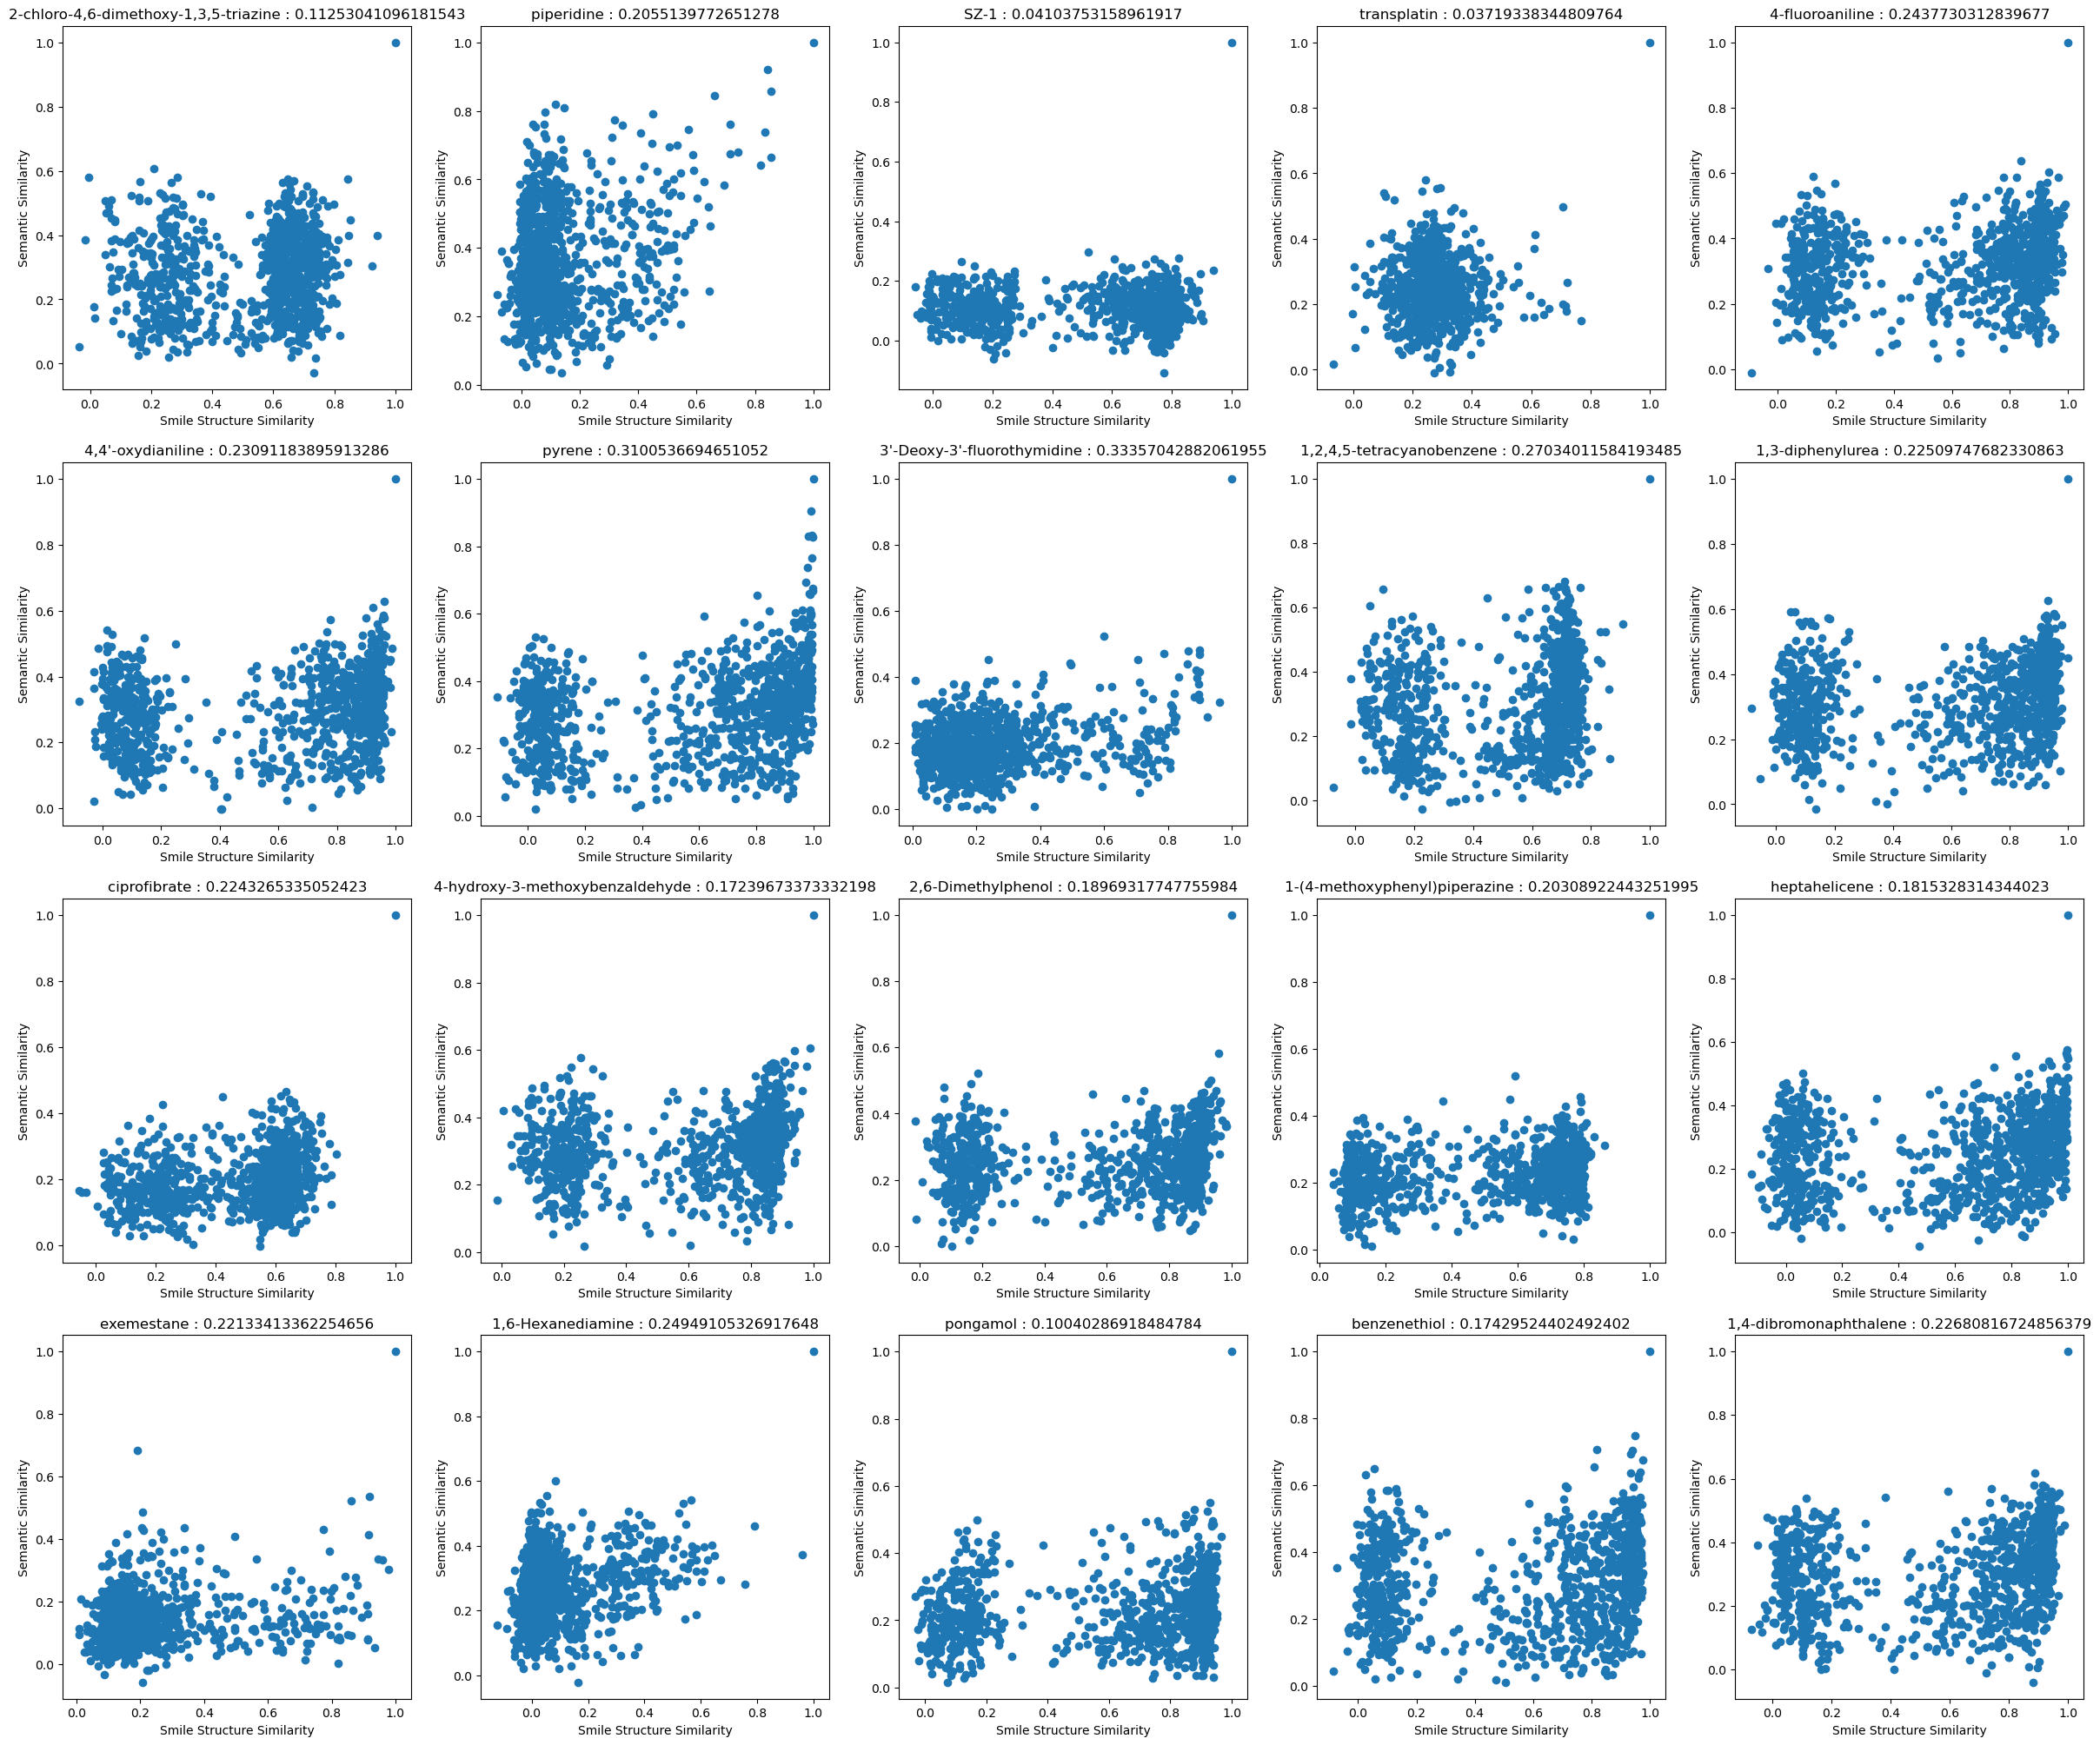

In [83]:
dist_sp = df_dist.sample(n=20, random_state=1)
fig, axes = plt.subplots(4, 5, figsize=(30, 25))

n = 0
for idx, row in dist_sp.iterrows():
    axe = axes.reshape((-1))[n]
    y = list(df_sem[idx])
    X = list(df_smi[idx])
    axe.scatter(X, y)
    axe.set_xlabel("Smile Structure Similarity")
    axe.set_ylabel("Semantic Similarity")
    axe.set_title("{} : {}".format(idx, pearsonr(X, y)[0]))
    n += 1
plt.show()

In [50]:
df_add.index = list(df_add['name'])
df_add

,name,word_freq,semantic,smile,atomic,geometric
(+)-aspidospermidine,(+)-aspidospermidine,15,"[0.17337348, -0.3568789, 0.03349426, -0.342206...","[-0.744335949, 0.0923662633, -0.357910395, -0....","[-16.981401, -16.848295, -17.021622, -16.97840...",['PATZIW']
(-)-Adrenaline,(-)-Adrenaline,21,"[0.378266782, 0.0607172847, 0.3967686, -0.0202...","[-0.814905405, -0.25902012, 0.0981947482, -0.6...","[-18.417313, -18.03368, -18.445927, -18.368427...",['ADRENL']
(-)-Epicatechin,(-)-Epicatechin,129,"[-0.13416506, 0.02672044, 0.328929, -0.3376658...","[-0.776835263, -0.0564182363, 0.0696076825, -0...","[-18.111425, -16.734394, -18.118, -18.050484, ...",['COWHUR']
(-)-Noradrenaline,(-)-Noradrenaline,23,"[0.0655271113, -0.122308001, -0.0707869977, -0...","[-0.79306275, -0.2277208, -0.02243627, -0.2832...","[-18.143618, -17.221077, -18.143715, -18.07799...",['NADREN']
(-)-deoxypodophyllotoxin,(-)-deoxypodophyllotoxin,10,"[0.05425612, -0.5526235, 0.5274869, -0.3697647...","[-0.834411085, 0.137109548, 0.222313315, -0.25...","[-17.632042, -16.738024, -17.664902, -17.60105...","['VAXXOH01', 'YOQXOU']"
...,...,...,...,...,...,...
viridicatin,viridicatin,28,"[-0.15006746, -0.912956, 0.22810888, -0.819405...","[-1.22181594, -0.388474464, 0.142942384, 0.059...","[-17.489208, -18.226345, -17.499388, -17.40784...",['DOJHAO01']
virosecurinine,virosecurinine,45,"[0.00989494, -0.27823803, 0.17010885, -0.44197...","[-0.0739553794, 0.285954088, 0.240951285, -0.3...","[-17.924335, -17.615856, -17.95199, -17.909348...",['FIDTEU']
voacamine,voacamine,64,"[0.38762978, -0.37111285, -0.10875563, -0.5215...","[-0.772047281, -0.0536762737, -0.0230637938, -...","[-17.086731, -17.633154, -17.118664, -17.07161...",['YURFAV']
weddellite,weddellite,281,"[0.15016489, -0.48716843, -0.05625443, 0.07016...","[-0.223173782, 0.052875869, 0.387791097, 0.547...","[-17.957497, -9.687341, -17.9029, -17.919159, ...","['GADTAK', 'WHWLTB01']"


In [79]:
wd_fq = []
pr_cor = []
pr_pval = []

outliers = []
for idx, row in df_dist.iterrows():

    y = list(df_sem[idx])
    X = list(df_smi[idx])
    pr = pearsonr(X, y)
    wd_fq.append(df_add.loc[idx]['word_freq'])
    pr_cor.append(pr[0])
    pr_pval.append(pr[1])

    if pr[0] < 0:
        outliers.append((idx, pr[0], df_add.loc[idx]['word_freq']))
#outliers=sorted(outliers,key=lambda x:w2v_md.wv.vocab[x].count,reverse=True)
outliers = sorted(outliers, key=lambda x: x[2], reverse=True)
outliers

[('chitosan', -0.10170003854998491, 65920),
 ('L1', -0.07067490755393002, 34137),
 ('purine', -0.04194394216449476, 25839),
 ('CP2', -0.05914810370972947, 808),
 ('tetrathiafulvalene', -0.1203680378674003, 695),
 ('isosorbide', -0.2228071588178725, 686),
 ('4-Aminopyridine', -0.07860173548043689, 338),
 ('DAF-2', -0.008665329268510446, 310),
 ('ruthenocene', -0.09068676698448888, 149),
 ('oxalamide', -0.07669032320386315, 121),
 ('methanesulfonamide', -0.1313196313377134, 99),
 ('decamethylferrocene', -0.30212242638361286, 85),
 ('6-Aminonicotinamide', -0.040055311670636994, 47),
 ('2,3,5,6-tetrafluoro-7,7,8,8-tetracyanoquinodimethane',
  -0.22106809851961415,
  37),
 ("2'-Deoxyadenosine", -0.02554988851521335, 35),
 ('p-Benzoquinone', -0.014174091704705929, 34),
 ('tetramethyltetraselenafulvalene', -0.23274437012265342, 20),
 ('2,5-dichloro-1,4-benzoquinone', -0.014890580173654019, 19),
 ('1,1,1,3,3,3-hexafluoropropan-2-ol', -0.0004556762598619587, 15),
 ('chryscandin', -0.00063180759

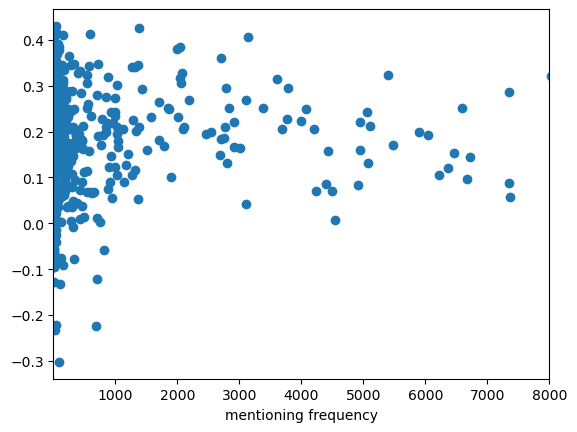

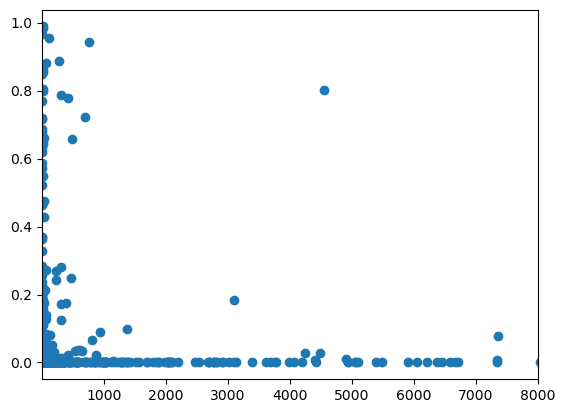

In [78]:
plt.scatter(wd_fq, pr_cor)
plt.xlim(1, 8000)
plt.xlabel("mentioning frequency")
plt.show()
plt.scatter(wd_fq, pr_pval)
plt.xlim(1, 8000)
plt.show()

1\predictive logistic regression.
2\outlier detection of individuals.
3\Spectrum clustering on the correlation matrix; check the variance eigen value of vectors, how many variance high enough, how many clusters we should try;
    3 clustering, compute the;

4\Try more on the embedding, alignment, clustering, kinds.

！！！get things organized

idexicality - indexical link, linguisitic anthropology, things pointing each other;
Eco, Encyclopedia , Kant
discrticulated

geertz, anthropology
global-local features, discourse in general;
local level analysis,
dialectial process, thick discription;
Interpretation of cultures;

materiality,考古人类学家,ontological turn;

#### Spector Clustering Analysis

In [8]:
df_sem = pd.read_csv('./sem_dist.csv')
df_sem.index = list(df_sem['Unnamed: 0'])
df_sem.drop(columns='Unnamed: 0', inplace=True)

df_smi = pd.read_csv('./smi_dist.csv')
df_smi.index = list(df_smi['Unnamed: 0'])
df_smi.drop(columns='Unnamed: 0', inplace=True)

df_ato = pd.read_csv('./ato_dist.csv')
df_ato.index = list(df_ato['Unnamed: 0'])
df_ato.drop(columns='Unnamed: 0', inplace=True)

In [9]:
df_sem
df_smi
df_ato

,(+)-aspidospermidine,(-)-Adrenaline,(-)-Epicatechin,(-)-Noradrenaline,(-)-deoxypodophyllotoxin,(-)-lobeline,"(1-pentyl-1H-indol-3-yl)(2,2,3,3-tetramethylcyclopropyl)methanone",(2-nitrophenyl)methanol,(E)-stilbene,(R)-flurbiprofen,...,uscharin,uzarigenin,vardenafil,viomellein,vioxanthin,viridicatin,virosecurinine,voacamine,weddellite,xylitol
(+)-aspidospermidine,1.000000,0.990986,0.984064,0.990650,0.993093,0.998763,0.998982,0.986863,0.992961,0.993637,...,0.994732,0.996428,0.995205,0.993724,0.994172,0.985889,0.996060,0.993677,0.909895,0.982823
(-)-Adrenaline,0.990986,1.000000,0.988875,0.994733,0.991633,0.992187,0.990813,0.994035,0.997385,0.994539,...,0.990494,0.990564,0.991158,0.992902,0.992725,0.995447,0.995709,0.987107,0.917233,0.983348
(-)-Epicatechin,0.984064,0.988875,1.000000,0.992897,0.993869,0.988292,0.986692,0.989893,0.986354,0.986831,...,0.986439,0.986278,0.985790,0.992378,0.991934,0.985036,0.989134,0.976892,0.949187,0.986307
(-)-Noradrenaline,0.990650,0.994733,0.992897,1.000000,0.991721,0.991633,0.990357,0.994852,0.991794,0.991687,...,0.992161,0.991448,0.991013,0.994245,0.994173,0.985957,0.995811,0.989957,0.933391,0.991890
(-)-deoxypodophyllotoxin,0.993093,0.991633,0.993869,0.991721,1.000000,0.997334,0.996518,0.987645,0.991462,0.993063,...,0.992543,0.996217,0.990485,0.997919,0.997748,0.986971,0.992476,0.985033,0.928397,0.988782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
viridicatin,0.985889,0.995447,0.985036,0.985957,0.986971,0.987161,0.985242,0.989489,0.994883,0.989275,...,0.982489,0.982978,0.984947,0.987754,0.987268,1.000000,0.988437,0.978302,0.899552,0.970997
virosecurinine,0.996060,0.995709,0.989134,0.995811,0.992476,0.995746,0.995283,0.992837,0.994326,0.996504,...,0.995449,0.995050,0.994727,0.995022,0.995330,0.988437,1.000000,0.994631,0.921621,0.986986
voacamine,0.993677,0.987107,0.976892,0.989957,0.985033,0.991999,0.991833,0.986755,0.988126,0.990741,...,0.995281,0.994755,0.990883,0.992121,0.992853,0.978302,0.994631,1.000000,0.902099,0.984631
weddellite,0.909895,0.917233,0.949187,0.933391,0.928397,0.916715,0.915026,0.934273,0.903654,0.906203,...,0.923354,0.913427,0.927220,0.921567,0.920623,0.899552,0.921621,0.902099,1.000000,0.924200


In [13]:
adjacentMatrix = np.array(df_sem)
degreeMatrix = np.sum(adjacentMatrix, axis=1)
laplacianMatrix = np.diag(degreeMatrix) - adjacentMatrix
sqrtDegreeMatrix = np.diag(1.0 / (degreeMatrix ** (0.5)))
LaplacianMatrix_normalized = np.dot(np.dot(sqrtDegreeMatrix, laplacianMatrix), sqrtDegreeMatrix)
lam, H = np.linalg.eig(LaplacianMatrix_normalized)

In [21]:
LaplacianMatrix_normalized

array([[ 9.95523859e-01, -8.35618969e-04, -5.59845504e-04, ...,
        -9.83320317e-04, -3.73507818e-04, -6.29789582e-04],
       [-8.35618969e-04,  9.91533654e-01, -2.32345561e-03, ...,
        -1.56679405e-03, -1.27944314e-03, -1.24558621e-03],
       [-5.59845504e-04, -2.32345561e-03,  9.95366473e-01, ...,
        -2.01145080e-03, -5.62964511e-04, -1.44903918e-03],
       ...,
       [-9.83320317e-04, -1.56679405e-03, -2.01145080e-03, ...,
         9.94733796e-01, -1.40659496e-03, -6.53860046e-04],
       [-3.73507818e-04, -1.27944314e-03, -5.62964511e-04, ...,
        -1.40659496e-03,  9.91802292e-01, -1.67651002e-03],
       [-6.29789582e-04, -1.24558621e-03, -1.44903918e-03, ...,
        -6.53860046e-04, -1.67651002e-03,  9.94134825e-01]])

In [25]:
from sklearn.cluster import KMeans


def normalization(matrix):  # 归一化
    sum = np.sqrt(np.sum(matrix ** 2, axis=1, keepdims=True))  # 求数组的正平方根
    nor_matrix = matrix / sum  # 求平均
    return nor_matrix


def spect_clustering(df):
    adjacentMatrix = np.array(df)
    degreeMatrix = np.sum(adjacentMatrix, axis=1)
    laplacianMatrix = np.diag(degreeMatrix) - adjacentMatrix
    sqrtDegreeMatrix = np.diag(1.0 / (degreeMatrix ** (0.5)))
    LaplacianMatrix_normalized = np.dot(np.dot(sqrtDegreeMatrix, laplacianMatrix), sqrtDegreeMatrix)
    lam, H = np.linalg.eig(LaplacianMatrix_normalized)

    t = np.argsort(lam)
    H = np.c_[H[:, t[0]], H[:, t[1]]]
    H = np.real(normalization(H))

    model = KMeans(n_clusters=20)
    model.fit(H)
    labels = model.labels_

    return labels

In [26]:
sem_label = spect_clustering(df_sem)
smi_label = spect_clustering(df_smi)
ato_label = spect_clustering(df_ato)

/Users/lyu/Opt/anaconda3/envs/accdis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/lyu/Opt/anaconda3/envs/accdis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/lyu/Opt/anaconda3/envs/accdis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
name2label=[]
for idx, nm in enumerate(df_sem.index):
    name2label.append((nm,sem_label[idx],smi_label[idx],ato_label[idx]))
name2label

[('(+)-aspidospermidine', 18, 8, 16),
 ('(-)-Adrenaline', 1, 4, 5),
 ('(-)-Epicatechin', 10, 8, 0),
 ('(-)-Noradrenaline', 17, 2, 3),
 ('(-)-deoxypodophyllotoxin', 9, 4, 13),
 ('(-)-lobeline', 11, 14, 16),
 ('(1-pentyl-1H-indol-3-yl)(2,2,3,3-tetramethylcyclopropyl)methanone',
  3,
  8,
  16),
 ('(2-nitrophenyl)methanol', 2, 4, 3),
 ('(E)-stilbene', 15, 10, 9),
 ('(R)-flurbiprofen', 5, 8, 1),
 ('(S)-Naproxen', 13, 8, 16),
 ("1,1'-Binaphthyl", 4, 5, 3),
 ("1,1'-binaphthalene", 4, 5, 3),
 ("1,1'-binaphthalene-2,2'-diol", 8, 5, 13),
 ("1,1'-biphenyl", 15, 5, 8),
 ('1,1,1,2-Tetrafluoroethane', 3, 12, 19),
 ('1,1,1,3,3,3-Hexafluoro-2-propanol', 2, 12, 1),
 ('1,1,1,3,3,3-hexafluoropropan-2-ol', 4, 12, 1),
 ('1,1,1-Trichloroethane', 17, 6, 2),
 ('1,1,1-trichloro-2,2-bis(4-chlorophenyl)ethane', 10, 13, 14),
 ('1,1,1-trifluoro-2-iodoethane', 4, 6, 9),
 ('1,1,2,2-Tetrachloroethane', 5, 16, 2),
 ('1,1,2,3,4,5-hexaphenylsilole', 4, 5, 1),
 ('1,1,2-trichloroethane', 19, 16, 2),
 ('1,1-Dichloro-2,2-b

In [30]:
sem_anchor={}
for i in range(20):
    smi=[x[2] for x in name2label if x[1]==i]
    ato=[x[3] for x in name2label if x[1]==i]
    sem_anchor[i]=(smi,ato)
sem_anchor

{0: ([3,
   13,
   0,
   2,
   15,
   13,
   6,
   10,
   5,
   14,
   18,
   8,
   15,
   8,
   14,
   1,
   6,
   12,
   12,
   6,
   15,
   16,
   10,
   0,
   6,
   19,
   19,
   11,
   3,
   15,
   5,
   12,
   1,
   13,
   14,
   17],
  [4,
   6,
   8,
   0,
   16,
   5,
   2,
   9,
   9,
   14,
   2,
   13,
   13,
   9,
   6,
   16,
   0,
   6,
   19,
   2,
   1,
   0,
   12,
   7,
   10,
   8,
   8,
   16,
   9,
   6,
   1,
   9,
   9,
   0,
   2,
   2]),
 1: ([4,
   13,
   10,
   15,
   4,
   8,
   7,
   3,
   0,
   6,
   15,
   6,
   15,
   13,
   12,
   8,
   2,
   1,
   8,
   14,
   8,
   18,
   2,
   15,
   18,
   16,
   15,
   15,
   10,
   1,
   1,
   8,
   15,
   14,
   1,
   7,
   4,
   11,
   8,
   4,
   15,
   2,
   4,
   1,
   4,
   9,
   13],
  [5,
   14,
   16,
   14,
   0,
   4,
   1,
   7,
   8,
   9,
   14,
   17,
   11,
   13,
   6,
   17,
   15,
   16,
   13,
   4,
   4,
   16,
   5,
   15,
   16,
   7,
   3,
   17,
   9,
   8,
   14,
   0,
   16,
   5,
   3,

In [ ]:
thre = 0

mention_x = []
mention_y = []

smile_euler = []
smile_cos = []

atm_euler = []
atm_cos = []

smt_euler = []
smt_cos = []

for idx_i, row_i in df_add.iloc[:-1].iterrows():
    for idx_j, row_j in df_add.iloc[idx_i + 1:].iterrows():
        mention_x.append(row_i["word_freq"])
        mention_y.append(row_j["word_freq"])
        smt_euler.append(get_euler_dist(row_i['semantic'], row_j['semantic']))
        smt_cos.append(get_cos_similar(row_i['semantic'], row_j['semantic']))
        smile_euler.append(get_euler_dist(row_i['smile'], row_j['smile']))
        smile_cos.append(get_cos_similar(row_i['smile'], row_j['smile']))
        atm_euler.append(get_euler_dist(row_i['atomic'], row_j['atomic']))
        atm_cos.append(get_cos_similar(row_i['atomic'], row_j['atomic']))

rg_df = pd.DataFrame({
    "y_euler": smt_euler,
    "y_cos": smt_cos,
    "x_freq": mention_x,
    "y_freq": mention_y,
    "smile_euler": smile_euler,
    "smile_cos": smile_cos,
    "atomic_euler": atm_euler,
    "atomic_cos": atm_cos
})
rg_df.to_csv('./rg_smile_atm.csv', index=False)
rg_df

In [19]:
rg_df = pd.read_csv('./rg_smile_atm.csv')
rg_df.columns = ['y_euler', 'y_cos', 'x_freq', 'y_freq', 'smile_euler', 'smile_cos',
                 'atomic_euler', 'atomic_cos']
rg_df

,y_euler,y_cos,x_freq,y_freq,smile_euler,smile_cos,atomic_euler,atomic_cos
0,7.356480,0.135740,15,21,9.521119,0.440545,17.670045,0.990986
1,6.637941,0.122931,15,129,8.559914,0.554187,20.588374,0.984064
2,7.722727,0.053811,15,23,9.247758,0.445768,16.590031,0.990650
3,6.810285,0.277617,15,10,7.691760,0.582366,13.232620,0.993093
4,6.584390,0.326956,15,39,8.019867,0.558857,5.385021,0.998763
...,...,...,...,...,...,...,...,...
464161,7.472766,0.105657,45,281,11.300672,0.161169,46.124108,0.921621
464162,6.616222,0.121934,45,7343,10.973194,0.193267,18.589073,0.986986
464163,6.606144,0.214079,64,281,9.937644,0.316744,51.152951,0.902099
464164,6.136308,0.117651,64,7343,8.271614,0.521585,20.247116,0.984631


#### Non-Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

y = np.log(np.array(rg_df['y_cos']) / (1 - np.array(rg_df['y_cos'])))
rg_df['lg_y'] = y
rg_df.dropna(inplace=True)
rg_df

,y_euler,y_cos,x_freq,y_freq,smile_euler,smile_cos,atomic_euler,atomic_cos,lg_y
0,7.356480,0.135740,15,21,9.521119,0.440545,17.670045,0.990986,-1.851131
1,6.637941,0.122931,15,129,8.559914,0.554187,20.588374,0.984064,-1.964965
2,7.722727,0.053811,15,23,9.247758,0.445768,16.590031,0.990650,-2.866972
3,6.810285,0.277617,15,10,7.691760,0.582366,13.232620,0.993093,-0.956312
4,6.584390,0.326956,15,39,8.019867,0.558857,5.385021,0.998763,-0.721984
...,...,...,...,...,...,...,...,...,...
464161,7.472766,0.105657,45,281,11.300672,0.161169,46.124108,0.921621,-2.135887
464162,6.616222,0.121934,45,7343,10.973194,0.193267,18.589073,0.986986,-1.974246
464163,6.606144,0.214079,64,281,9.937644,0.316744,51.152951,0.902099,-1.300511
464164,6.136308,0.117651,64,7343,8.271614,0.521585,20.247116,0.984631,-2.014865


In [30]:
LR = LinearRegression()
LR.fit(rg_df[['smile_euler', 'atomic_cos']], rg_df['lg_y'])
print(LR.score(rg_df[['smile_euler', 'atomic_cos']], rg_df['lg_y']))
lgy_pred = LR.predict(rg_df[['smile_euler', 'atomic_cos']])
y_pred = 1 / (1 + np.exp(-np.array(lgy_pred)))
print(mean_squared_error(rg_df['y_cos'], y_pred))
print(r2_score(rg_df['y_cos'], y_pred))

0.0032019813917576467
0.015680259414156298
-0.03418547830928298


In [31]:
LR = Lasso()
LR.fit(rg_df[['smile_euler', 'atomic_cos']], rg_df['lg_y'])
print(LR.score(rg_df[['smile_euler', 'atomic_cos']], rg_df['lg_y']))
lgy_pred = LR.predict(rg_df[['smile_euler', 'atomic_cos']])
y_pred = 1 / (1 + np.exp(-np.array(lgy_pred)))
print(mean_squared_error(rg_df['y_cos'], y_pred))
print(r2_score(rg_df['y_cos'], y_pred))

0.0
0.015750157296822005
-0.03879556627454828


In [32]:
LR = Ridge()
LR.fit(rg_df[['smile_euler', 'atomic_cos']], rg_df['lg_y'])
print(LR.score(rg_df[['smile_euler', 'atomic_cos']], rg_df['lg_y']))
lgy_pred = LR.predict(rg_df[['smile_euler', 'atomic_cos']])
y_pred = 1 / (1 + np.exp(-np.array(lgy_pred)))
print(mean_squared_error(rg_df['y_cos'], y_pred))
print(r2_score(rg_df['y_cos'], y_pred))

0.0032019798543425626
0.015680257827720256
-0.034185373676504094


In [32]:
%%time
thresholds = np.arange(0, 10000, 500)

linear_score = np.zeros(len(thresholds))
mse_s = np.zeros(len(thresholds))
r2_scores = np.zeros(len(thresholds))

linear_score_log = np.zeros(len(thresholds))
mse_s_log = np.zeros(len(thresholds))
r2_scores_log = np.zeros(len(thresholds))

linear_score_ridge = np.zeros(len(thresholds))
mse_s_ridge = np.zeros(len(thresholds))
r2_scores_ridge = np.zeros(len(thresholds))

for i, thr in tqdm(list(enumerate(thresholds))):
    rg_df_wk = rg_df[rg_df['x_freq'] >= thr][rg_df['y_freq'] >= thr]

    LR = LinearRegression()
    LR.fit(rg_df_wk[['smile_euler', 'atomic_cos']], rg_df_wk['y_cos'])
    linear_score[i] = LR.score(rg_df_wk[['smile_euler', 'atomic_cos']], rg_df_wk['y_cos'])
    y_pred = LR.predict(rg_df_wk[['smile_euler', 'atomic_cos']])
    mse_s[i] = mean_squared_error(rg_df_wk['y_cos'], y_pred)
    r2_scores[i] = r2_score(rg_df_wk['y_cos'], y_pred)

    LR = LinearRegression()
    LR.fit(rg_df_wk[['smile_euler', 'atomic_cos']], rg_df_wk['lg_y'])
    linear_score_log[i] = LR.score(rg_df_wk[['smile_euler', 'atomic_cos']], rg_df_wk['lg_y'])
    lgy_pred = LR.predict(rg_df_wk[['smile_euler', 'atomic_cos']])
    y_pred = 1 / (1 + np.exp(-np.array(lgy_pred)))
    mse_s_log[i] = mean_squared_error(rg_df_wk['y_cos'], y_pred)
    r2_scores_log[i] = r2_score(rg_df_wk['y_cos'], y_pred)

    LR = Ridge()
    LR.fit(rg_df_wk[['smile_euler', 'atomic_cos']], rg_df_wk['lg_y'])
    linear_score_ridge[i] = LR.score(rg_df_wk[['smile_euler', 'atomic_cos']], rg_df_wk['lg_y'])
    lgy_pred = LR.predict(rg_df_wk[['smile_euler', 'atomic_cos']])
    y_pred = 1 / (1 + np.exp(-np.array(lgy_pred)))
    mse_s_ridge[i] = mean_squared_error(rg_df_wk['y_cos'], y_pred)
    r2_scores_ridge[i] = r2_score(rg_df_wk['y_cos'], y_pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(thresholds, linear_score_log, lw=2)
axes[0].plot(thresholds, linear_score, lw=2)
axes[0].plot(thresholds, linear_score_ridge, lw=2)
axes[0].set_xlim([0, 10000])
axes[0].set_ylabel('linear_score', fontsize=15)
axes[0].set_xlabel('Threshold on Mentions', fontsize=15)

axes[1].plot(thresholds, mse_s_log, lw=2)
axes[1].plot(thresholds, mse_s, lw=2)
axes[1].plot(thresholds, mse_s_ridge, lw=2)
axes[1].set_xlim([0, 10000])
axes[1].set_ylabel('mean_squared_error', fontsize=15)
axes[1].set_xlabel('Threshold on Mentions', fontsize=15)

axes[2].plot(thresholds, r2_scores_log, lw=2)
axes[2].plot(thresholds, linear_score, lw=2)
axes[2].plot(thresholds, linear_score_ridge, lw=2)
axes[2].set_xlim([0, 10000])
axes[2].set_ylabel('r2_score', fontsize=15)
axes[2].set_xlabel('Threshold on Mentions', fontsize=15)

plt.subplots_adjust(right=1.3)

  0%|          | 0/20 [00:00<?, ?it/s]


NameError: name 'rg_df' is not defined

#### Naive Relationship

100%|██████████| 100/100 [00:00<00:00, 154.82it/s]


CPU times: user 2.26 s, sys: 544 ms, total: 2.81 s
Wall time: 664 ms


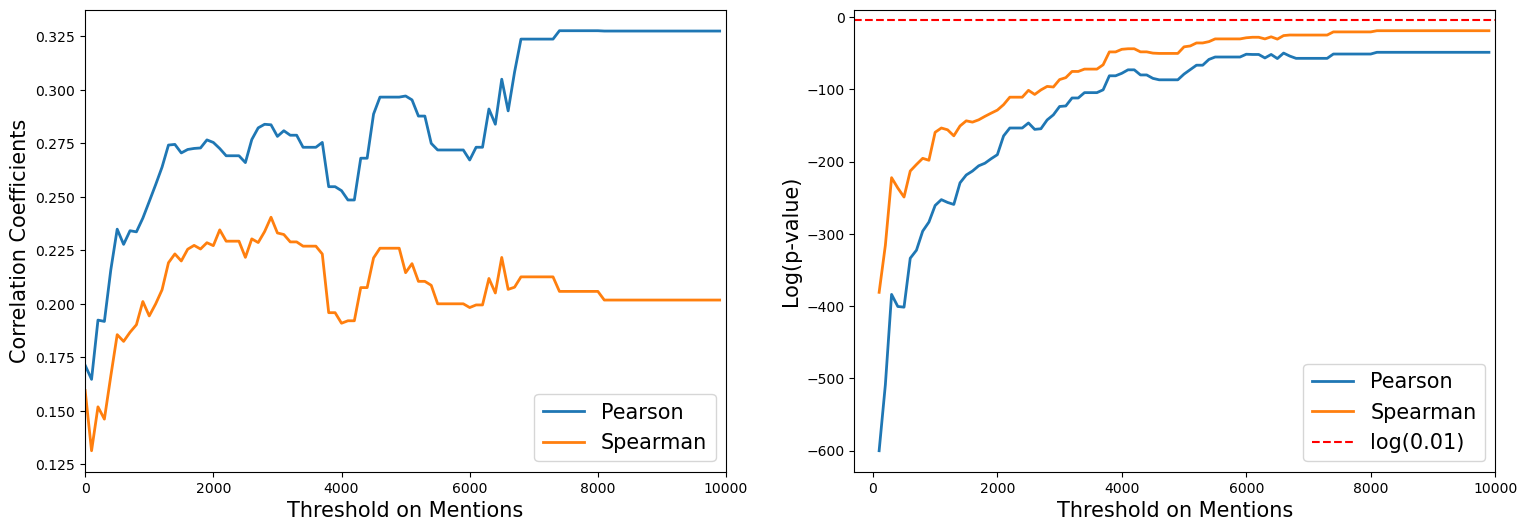

In [48]:
% % time
thresholds = np.arange(0, 10000, 100)
sp_coefs = np.zeros(len(thresholds))
sp_pvals = np.zeros(len(thresholds))
pr_coefs = np.zeros(len(thresholds))
pr_pvals = np.zeros(len(thresholds))

for i, thr in tqdm(list(enumerate(thresholds))):
    rg_df_wk = rg_df[rg_df['x_freq'] >= thr][rg_df['y_freq'] >= thr]
    X = list(rg_df_wk["y_cos"])
    y = list(rg_df_wk["smile_cos"])
    sp = spearmanr(X, y)
    pr = pearsonr(X, y)
    sp_coefs[i] = sp[0]
    sp_pvals[i] = np.log(sp[1]) if sp[1] > 0 else np.nan
    pr_coefs[i] = pr[0]
    pr_pvals[i] = np.log(pr[1]) if pr[1] > 0 else np.nan

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(thresholds, pr_coefs, lw=2, label='Pearson')
axes[0].plot(thresholds, sp_coefs, lw=2, label='Spearman')
axes[0].set_xlim([0, 10000])
axes[0].set_ylabel('Correlation Coefficients', fontsize=15)
axes[0].set_xlabel('Threshold on Mentions', fontsize=15)
axes[0].legend(fontsize=15, loc=4)

axes[1].plot(thresholds, pr_pvals, lw=2, label='Pearson')
axes[1].plot(thresholds, sp_pvals, lw=2, label='Spearman')
axes[1].axhline(y=np.log(0.01), color='r', ls='--', label='log(0.01)')
axes[1].set_xlim([-300, 10000])
axes[1].set_ylabel('Log(p-value)', fontsize=15)
axes[1].set_xlabel('Threshold on Mentions', fontsize=15)
axes[1].legend(fontsize=15, loc=4)

plt.subplots_adjust(right=1.3)

In [ ]:
% % time
thresholds = np.arange(0, 10000, 100)
sp_coefs = np.zeros(len(thresholds))
sp_pvals = np.zeros(len(thresholds))
pr_coefs = np.zeros(len(thresholds))
pr_pvals = np.zeros(len(thresholds))

for i, thr in tqdm(list(enumerate(thresholds))):
    rg_df_wk = rg_df[rg_df['x_freq'] >= thr][rg_df['y_freq'] >= thr]
    X = list(rg_df_wk["y_cos"])
    y = list(rg_df_wk["smile_cos"])
    sp = spearmanr(X, y)
    pr = pearsonr(X, y)
    sp_coefs[i] = sp[0]
    sp_pvals[i] = np.log(sp[1]) if sp[1] > 0 else np.nan
    pr_coefs[i] = pr[0]
    pr_pvals[i] = np.log(pr[1]) if pr[1] > 0 else np.nan

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(thresholds, pr_coefs, lw=2, label='Pearson')
axes[0].plot(thresholds, sp_coefs, lw=2, label='Spearman')
axes[0].set_xlim([0, 10000])
axes[0].set_ylabel('Correlation Coefficients', fontsize=15)
axes[0].set_xlabel('Threshold on Mentions', fontsize=15)
axes[0].legend(fontsize=15, loc=4)

axes[1].plot(thresholds, pr_pvals, lw=2, label='Pearson')
axes[1].plot(thresholds, sp_pvals, lw=2, label='Spearman')
axes[1].axhline(y=np.log(0.01), color='r', ls='--', label='log(0.01)')
axes[1].set_xlim([-300, 10000])
axes[1].set_ylabel('Log(p-value)', fontsize=15)
axes[1].set_xlabel('Threshold on Mentions', fontsize=15)
axes[1].legend(fontsize=15, loc=4)

plt.subplots_adjust(right=1.3)

In [1]:
rg_df = pd.read_csv('./rg_smile_atm.csv')
rg_df

NameError: name 'pd' is not defined

In [ ]:
thre = 0
rg_df_wk = rg_df[rg_df['x_freq'] >= thre][rg_df['y_freq'] >= thre]
mdl1 = ols("y_cos ~  smile_cos", data=rg_df_wk).fit()
print(mdl1.summary())
mdl2 = ols("y_cos ~ atomic_cos", data=rg_df_wk).fit()
print(mdl2.summary())
mdl3 = ols("y_cos ~ smile_cos + atomic_cos", data=rg_df_wk).fit()
print(mdl3.summary())

In [ ]:
thre = 1500
rg_df_wk = rg_df[rg_df['x_freq'] >= thre][rg_df['y_freq'] >= thre]
mdl1 = ols("y_cos ~  smile_cos", data=rg_df_wk).fit()
print(mdl1.summary())
mdl2 = ols("y_cos ~ atomic_cos", data=rg_df_wk).fit()
print(mdl2.summary())
mdl3 = ols("y_cos ~ smile_cos + atomic_cos", data=rg_df_wk).fit()
print(mdl3.summary())

In [ ]:
thre = 5000
rg_df_wk = rg_df[rg_df['x_freq'] >= thre][rg_df['y_freq'] >= thre]
mdl1 = ols("y_cos ~  smile_cos", data=rg_df_wk).fit()
print(mdl1.summary())
mdl2 = ols("y_cos ~ atomic_cos", data=rg_df_wk).fit()
print(mdl2.summary())
mdl3 = ols("y_cos ~ smile_cos + atomic_cos", data=rg_df_wk).fit()
print(mdl3.summary())

In [6]:
rg_df_wk

,y_euler,y_cos,x_freq,y_freq,smile_euler,smile_cos,atomic_euler,stomic_cos
219703,4.337496,0.207108,13992,2806,9.255151,0.388256,18.884536,0.987875
219705,4.189567,0.087782,13992,3017,10.600664,0.428990,20.270110,0.984714
219708,3.565605,0.322177,13992,1836284,13.206774,0.187993,27.200036,0.969002
219709,4.125549,0.257243,13992,1572,12.895923,0.327012,33.060528,0.952444
219730,4.315383,0.133524,13992,13381,11.049633,0.177769,15.024698,0.992829
...,...,...,...,...,...,...,...,...
463987,4.982118,0.142600,2042,2914,13.041415,0.014728,24.379078,0.976390
463994,4.109209,0.372669,2042,7343,12.264042,0.307779,22.705506,0.980506
464113,4.807479,0.110623,101640,2914,12.972368,0.097109,20.568769,0.981904
464120,3.891974,0.373277,101640,7343,12.215095,0.351109,21.423550,0.984618


In [9]:
thre = 1500
rg_df_wk = rg_df[rg_df['x_freq'] >= thre][rg_df['y_freq'] >= thre]
mdl1 = ols("stomic_cos ~  smile_cos", data=rg_df_wk).fit()
print(mdl1.summary())
pearsonr(rg_df_wk['stomic_cos'], rg_df_wk['smile_cos'])

                            OLS Regression Results                            
Dep. Variable:             stomic_cos   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     546.4
Date:                Mon, 17 Apr 2023   Prob (F-statistic):          1.92e-115
Time:                        10:43:41   Log-Likelihood:                 14831.
No. Observations:                5671   AIC:                        -2.966e+04
Df Residuals:                    5669   BIC:                        -2.965e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9701      0.000   2374.771      0.0

/var/folders/zw/thvqht1n2q9ggd09wgsw76th0000gn/T/ipykernel_73758/152559295.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rg_df_wk = rg_df[rg_df['x_freq'] >= thre][rg_df['y_freq'] >= thre]


(0.2964907554919313, 1.921196405676122e-115)

In [10]:
thre = 0
rg_df_wk = rg_df[rg_df['x_freq'] >= thre][rg_df['y_freq'] >= thre]
mdl1 = ols("stomic_cos ~  smile_cos", data=rg_df_wk).fit()
print(mdl1.summary())
pearsonr(rg_df_wk['stomic_cos'], rg_df_wk['smile_cos'])

                            OLS Regression Results                            
Dep. Variable:             stomic_cos   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                 1.119e+04
Date:                Mon, 17 Apr 2023   Prob (F-statistic):               0.00
Time:                        10:48:33   Log-Likelihood:             1.1356e+06
No. Observations:              464166   AIC:                        -2.271e+06
Df Residuals:                  464164   BIC:                        -2.271e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9718   5.24e-05   1.85e+04      0.0

(0.1534556649304496, 0.0)